In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from matplotlib.ticker import ScalarFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from auto_arima import auto_arima_like_with_csv

OUTPUT_DIR = "./results/"

In [27]:
# 1. Leer el CSV original
df = pd.read_csv("../data/synthetic_data/datos_a_completar.csv")

# 2. Convertir fechas
df["START_DATE"] = pd.to_datetime(df["START_DATE"])
df["END_DATE"] = pd.to_datetime(df["END_DATE"])

# 3. Crear serie de tiempo con frecuencia de 1 minuto
serie = pd.Series(df["ACTUAL_USAGE"].values, index=df["START_DATE"])
serie = serie.resample("1T").sum()

# 4. Guardar la serie en un nuevo CSV
serie_df = serie.reset_index()
serie_df.columns = ["fecha", "consumo"]
serie_df.to_csv(OUTPUT_DIR + "serie_tiempo.csv", index=False)

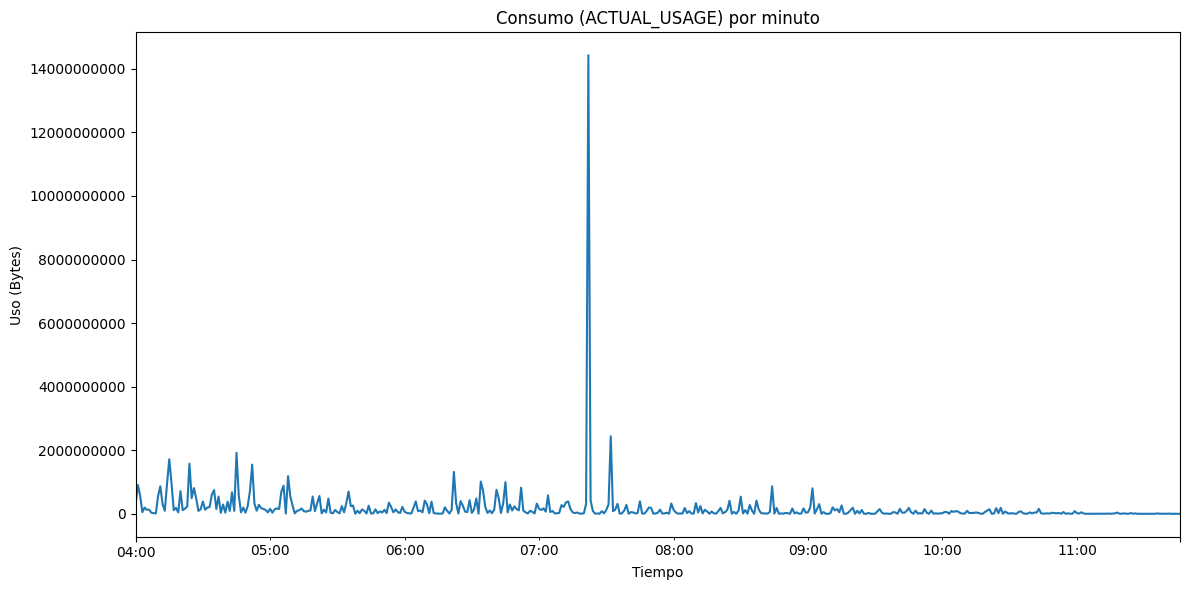

In [28]:
# 5. Graficar sin notación científica
plt.figure(figsize=(12,6))
ax = serie.plot()

# Forzar formato normal en eje Y
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style="plain", axis="y")

plt.title("Consumo (ACTUAL_USAGE) por minuto")
plt.xlabel("Tiempo")
plt.ylabel("Uso (Bytes)")
plt.tight_layout()

# 6. Guardar la imagen
plt.savefig(OUTPUT_DIR + "serie_tiempo.png", dpi=300)
plt.show()

<Figure size 1200x800 with 0 Axes>

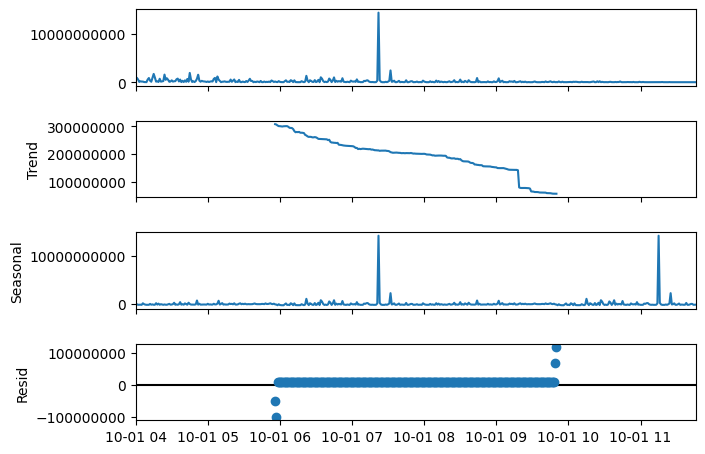

In [29]:
# 1. Descomposición aditiva
result = seasonal_decompose(serie, model="additive", period=len(serie) // 2)

# 2. Graficar los componentes
plt.figure(figsize=(12,8))
axes = result.plot()
for ax in axes.axes: 
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False)) 
    ax.ticklabel_format(style="plain", axis="y")
    
plt.savefig(OUTPUT_DIR + "descomposition.png", dpi=300)
plt.show()

KPSS Statistic: 1.1947097573013488
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
La serie NO es estacionaria → se recomienda diferenciar.


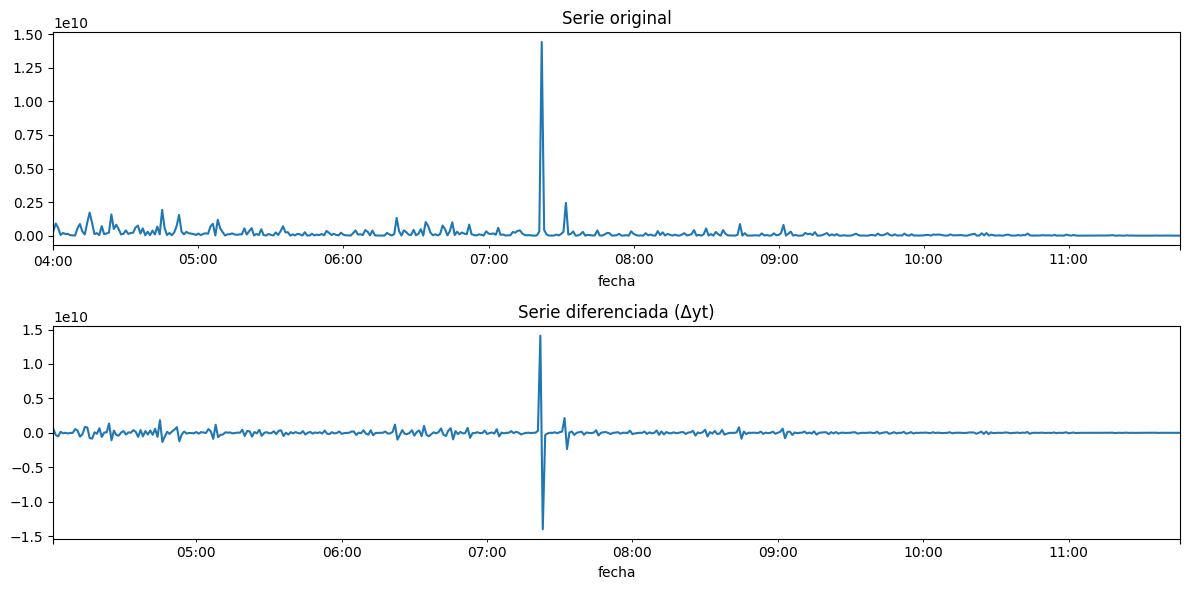

In [30]:
# Supongamos que ya tienes tu serie:
serie = pd.Series(serie_df["consumo"].values, index=serie_df["fecha"]).asfreq("T")

# 1. Diferenciación de primer orden (Δyt = yt - yt-1)
serie_diff = serie.diff().dropna()

# 2. Transformaciones para estabilizar varianza
serie_log = np.log(serie.replace(0, np.nan)).dropna()   # logaritmo
serie_sqrt = np.sqrt(serie).dropna()                   # raíz cuadrada

# 3. Prueba KPSS (equivalente a urkpssTest en R)
# H0: la serie es estacionaria
stat, p_value, lags, crit = kpss(serie.dropna(), regression="c", nlags="auto")

print("KPSS Statistic:", stat)
print("p-value:", p_value)
print("Critical Values:", crit)

if p_value < 0.05:
    print("La serie NO es estacionaria → se recomienda diferenciar.")
else:
    print("La serie parece estacionaria.")

# 4. Graficar original vs diferenciada
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
serie.plot(title="Serie original")
plt.subplot(2,1,2)
serie_diff.plot(title="Serie diferenciada (Δyt)")
plt.tight_layout()
plt.savefig(OUTPUT_DIR + "serie_diferenciada.png", dpi=300)
plt.show()


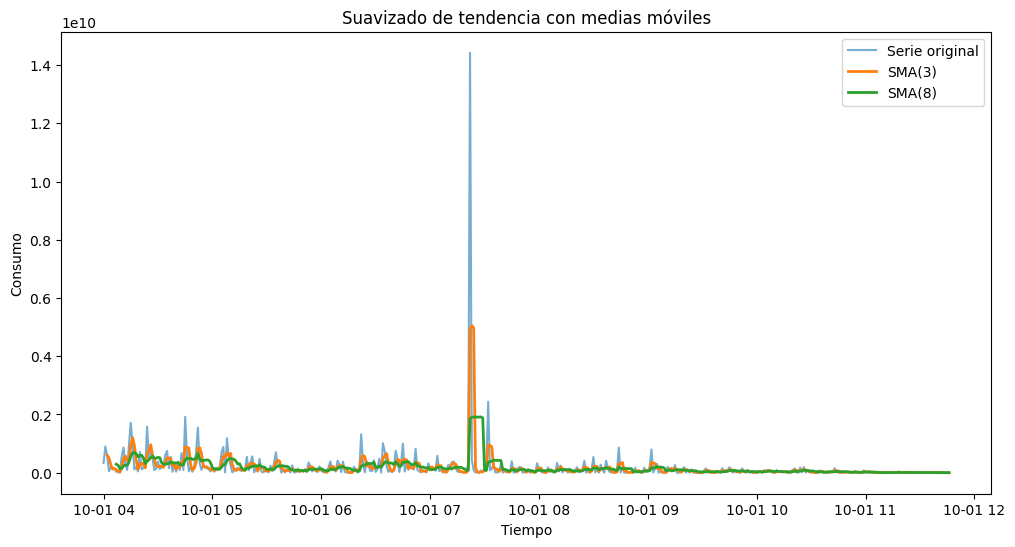

In [31]:
# 1. Media móvil simple de orden 3
SMA3 = serie.rolling(window=3).mean()

# 2. Media móvil simple de orden 8
SMA8 = serie.rolling(window=8).mean()

# 3. Graficar original y suavizadas
plt.figure(figsize=(12,6))
plt.plot(serie, label="Serie original", alpha=0.6)
plt.plot(SMA3, label="SMA(3)", linewidth=2)
plt.plot(SMA8, label="SMA(8)", linewidth=2)
plt.title("Suavizado de tendencia con medias móviles")
plt.xlabel("Tiempo")
plt.ylabel("Consumo")
plt.legend()
plt.savefig(OUTPUT_DIR + "suavizado.png", dpi=300)
plt.show()

### Holt-Winters (Exponential Smoothing)

In [32]:
# 1. Ajuste Holt-Winters solo nivel
# hw_model = ExponentialSmoothing(serie, trend=None, seasonal=None).fit(smoothing_level=0.94)

# Ajuste Holt-Winters con tendencia o estacionalidad incluida
hw_model = ExponentialSmoothing(serie, trend="add", seasonal="add", seasonal_periods=12).fit()


print("Alpha:", hw_model.params['smoothing_level'])

Alpha: 0.06125338759197191


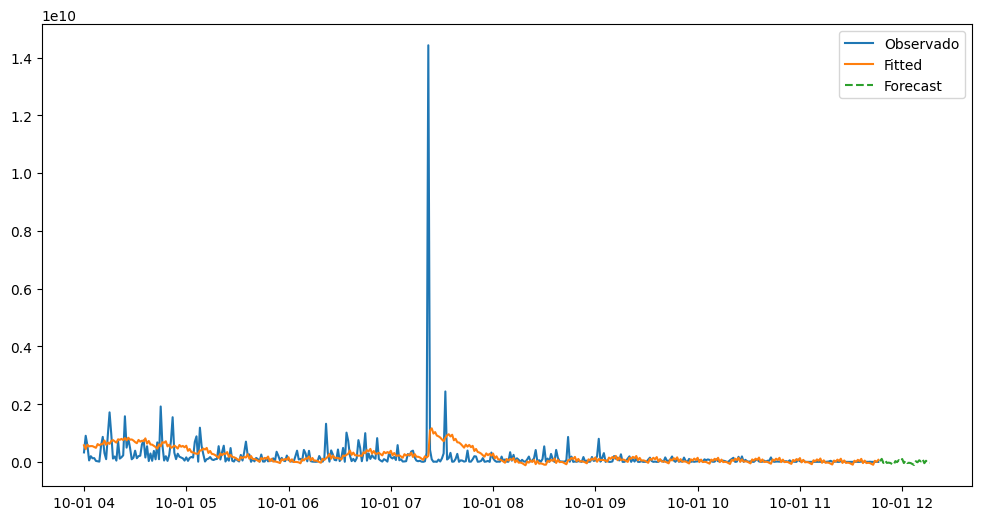

In [33]:
# 2. Predicción a futuro (h pasos)
h = 30
forecast = hw_model.forecast(h)

plt.figure(figsize=(12,6))
plt.plot(serie, label="Observado")
plt.plot(hw_model.fittedvalues, label="Fitted")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.savefig(OUTPUT_DIR + "hw_forecast.png", dpi=300)
plt.show()

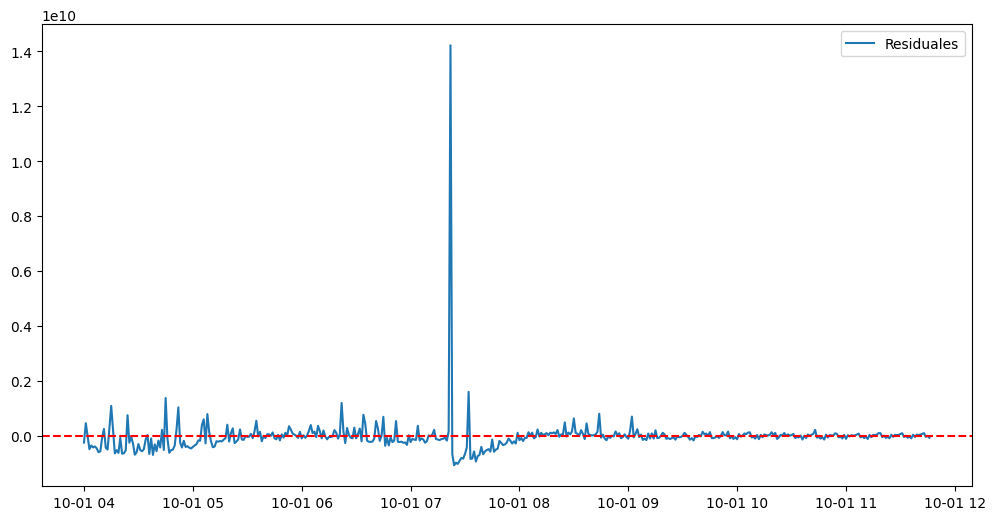

In [34]:
# 4. Residuales
residuals = serie - hw_model.fittedvalues
plt.figure(figsize=(12,6))
plt.plot(residuals, label="Residuales")
plt.axhline(0, color="red", linestyle="--")
plt.legend()
plt.savefig(OUTPUT_DIR + "hw_residuales.png", dpi=300)
plt.show()

### ARIMA

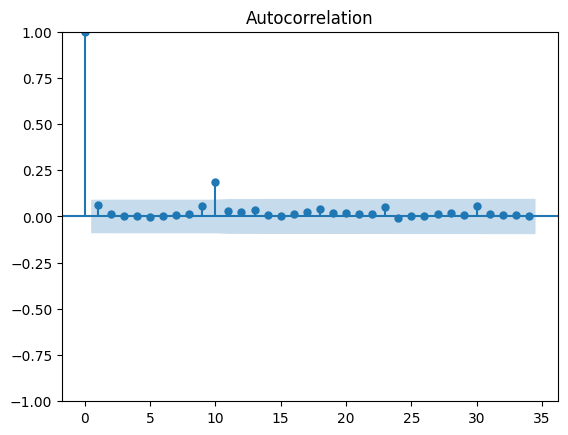

In [35]:
# 1. Graficar ACF y PACF para escoger p y q
plot_acf(serie.dropna(), lags=34)
plt.savefig(OUTPUT_DIR + "acf.png", dpi=300)
plt.show()

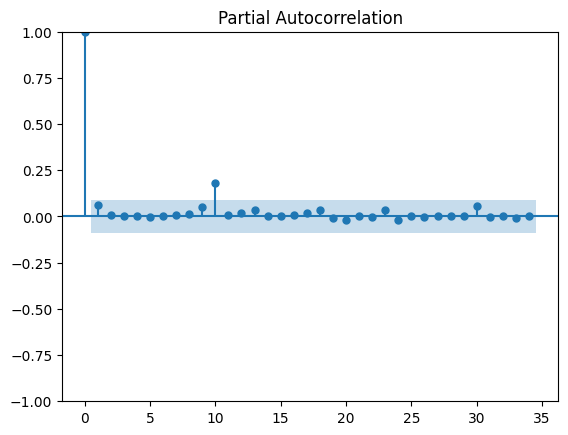

In [36]:
plot_pacf(serie.dropna(), lags=34)
plt.savefig(OUTPUT_DIR + "pacf.png", dpi=300)
plt.show()

In [37]:
# 2. Ajustar modelo ARIMA(p,d,q)
model = ARIMA(serie, order=(1,1,1)) 
_fit = model.fit()
print(_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  467
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10165.606
Date:                Thu, 15 Jan 2026   AIC                          20337.212
Time:                        21:19:36   BIC                          20349.645
Sample:                    10-01-2025   HQIC                         20342.105
                         - 10-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0390      0.073      0.531      0.595      -0.105       0.183
ma.L1         -0.9831      0.015    -65.964      0.000      -1.012      -0.954
sigma2      6.334e+17   1.56e-19   4.07e+36      0.0

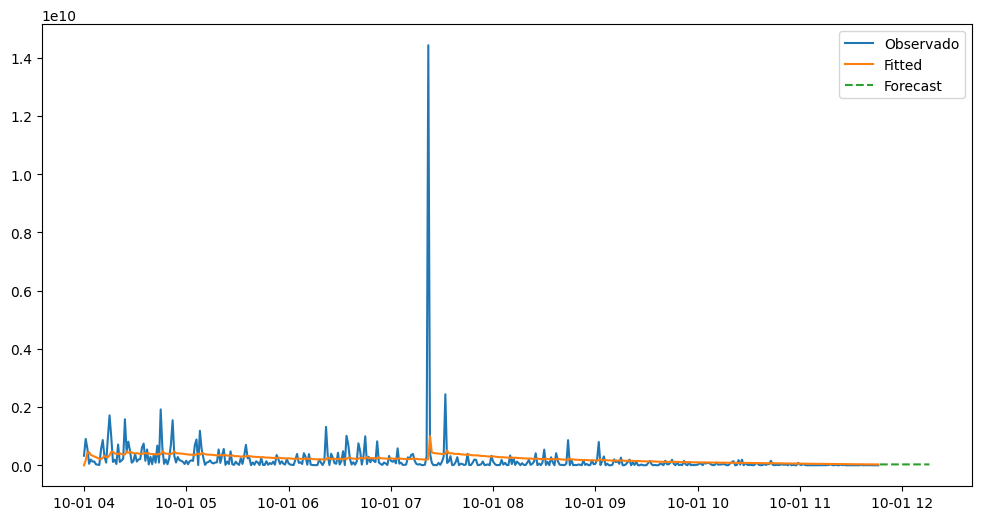

In [38]:
# 3. Predicción
forecast = _fit.forecast(steps=30)

plt.figure(figsize=(12,6))
plt.plot(serie, label="Observado")
plt.plot(_fit.fittedvalues, label="Fitted")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.savefig(OUTPUT_DIR + "arima_forecast.png", dpi=300)
plt.show()


In [39]:
residuals = _fit.resid.dropna()

<Figure size 1000x500 with 0 Axes>

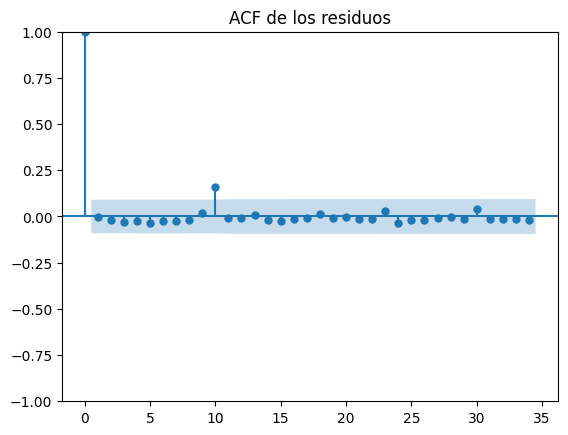

In [40]:
# 1. Correlograma de los residuales (ACF)
plt.figure(figsize=(10,5))
plot_acf(residuals, lags=34)
plt.title("ACF de los residuos")
plt.show()

In [41]:
# 2. Prueba de Ljung-Box (equivalente a Box.test en R)
ljung_box = acorr_ljungbox(residuals, lags=[20], return_df=True)
print(ljung_box)

      lb_stat  lb_pvalue
20  15.832393   0.726966


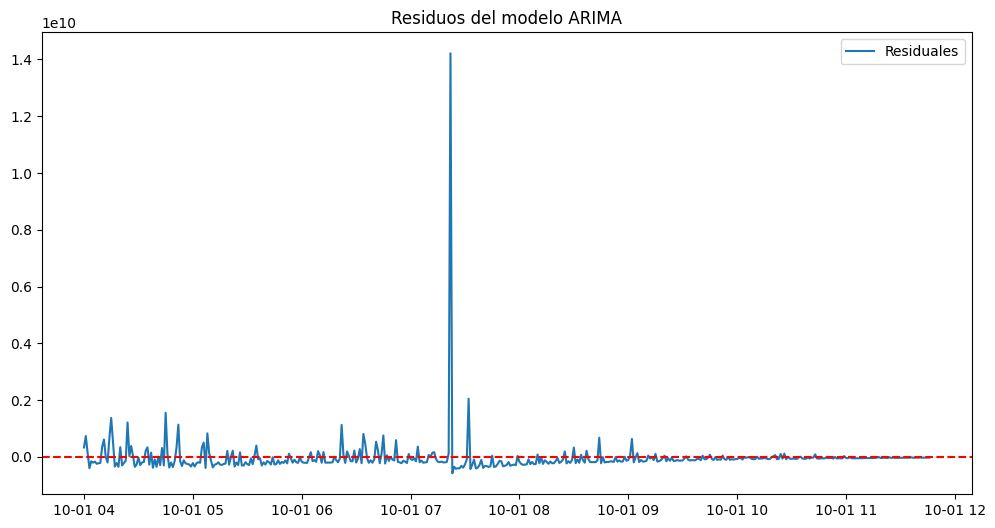

In [42]:
# 3. Serie temporal de los residuos
plt.figure(figsize=(12,6))
plt.plot(residuals, label="Residuales")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuos del modelo ARIMA")
plt.legend()
plt.savefig(OUTPUT_DIR + "arima_residuos.png", dpi=300)
plt.show()

<Figure size 600x600 with 0 Axes>

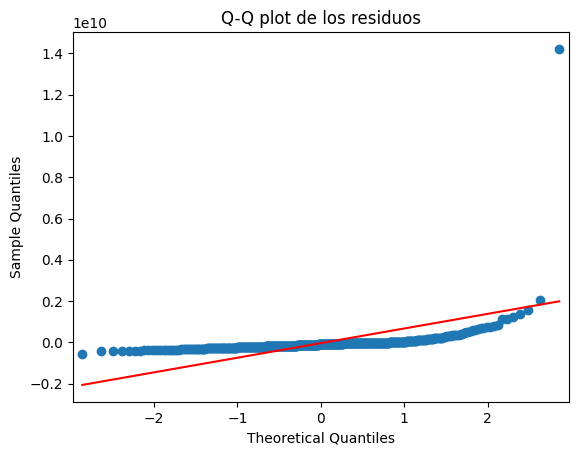

In [43]:
# 4. Gráfico Q-Q (normalidad de los residuos)
plt.figure(figsize=(6,6))
sm.qqplot(residuals, line="s")
plt.title("Q-Q plot de los residuos")
plt.savefig(OUTPUT_DIR + "arima_q_q_residuos.png", dpi=300)
plt.show()

In [44]:
# 2. Ajustar modelo ARIMA(p,d,q)
_fit = auto_arima_like_with_csv(serie, p_range=(0,3), d_range=(0,2), q_range=(0,3))

print(_fit.summary())

Mejor modelo ARIMA(0, 1, 3) con AIC=20331.78
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  467
Model:                 ARIMA(0, 1, 3)   Log Likelihood              -10161.890
Date:                Thu, 15 Jan 2026   AIC                          20331.781
Time:                        21:19:44   BIC                          20348.357
Sample:                    10-01-2025   HQIC                         20338.305
                         - 10-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9443      0.069    -13.732      0.000      -1.079      -0.810
ma.L2         -0.0526      0.195     -0.269      0.788      -0.435       0.330
ma.L3  

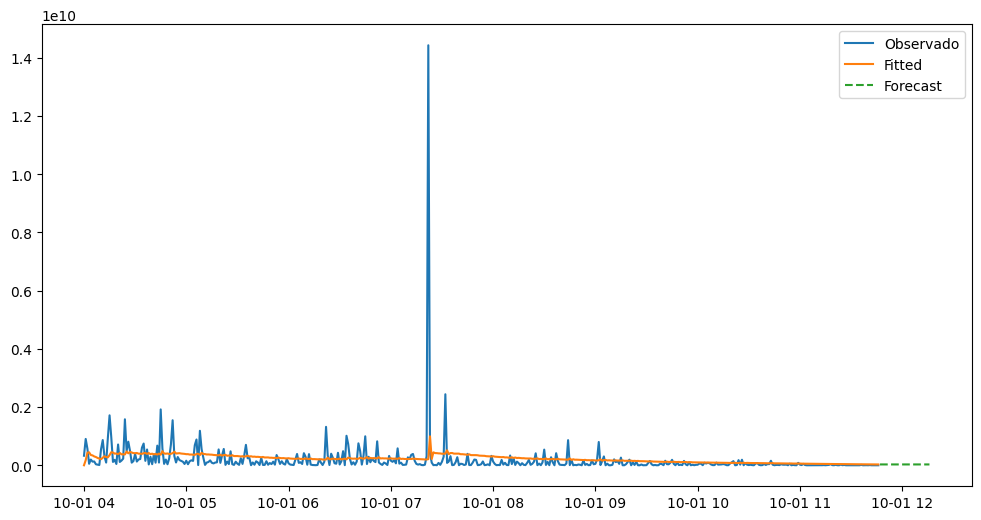

In [45]:
# 3. Predicción
forecast = _fit.forecast(steps=30)

plt.figure(figsize=(12,6))
plt.plot(serie, label="Observado")
plt.plot(_fit.fittedvalues, label="Fitted")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.savefig(OUTPUT_DIR + "arima_auto_forecast.png", dpi=300)
plt.show()

In [46]:
residuals = _fit.resid.dropna()

<Figure size 1000x500 with 0 Axes>

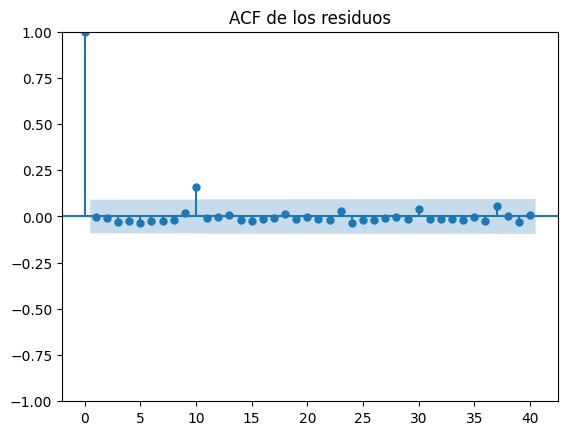

In [47]:
# 1. Correlograma de los residuales (ACF)
plt.figure(figsize=(10,5))
plot_acf(residuals, lags=40)
plt.title("ACF de los residuos")
plt.show()

In [48]:
# 2. Prueba de Ljung-Box (equivalente a Box.test en R)
ljung_box = acorr_ljungbox(residuals, lags=[20], return_df=True)
print(ljung_box)

      lb_stat  lb_pvalue
20  15.643226   0.738497


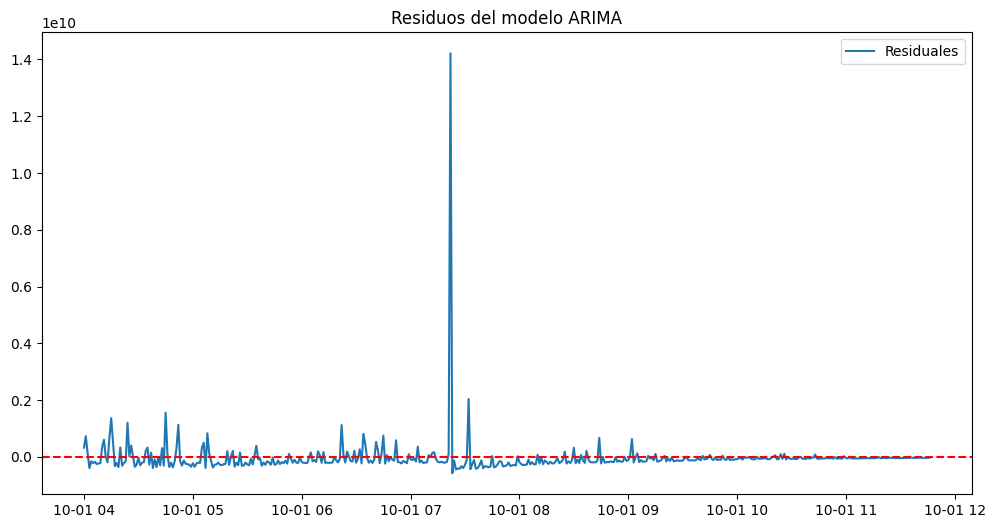

In [49]:
# 3. Serie temporal de los residuos
plt.figure(figsize=(12,6))
plt.plot(residuals, label="Residuales")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuos del modelo ARIMA")
plt.legend()
plt.savefig(OUTPUT_DIR + "arima_auto_residuos.png", dpi=300)
plt.show()

<Figure size 600x600 with 0 Axes>

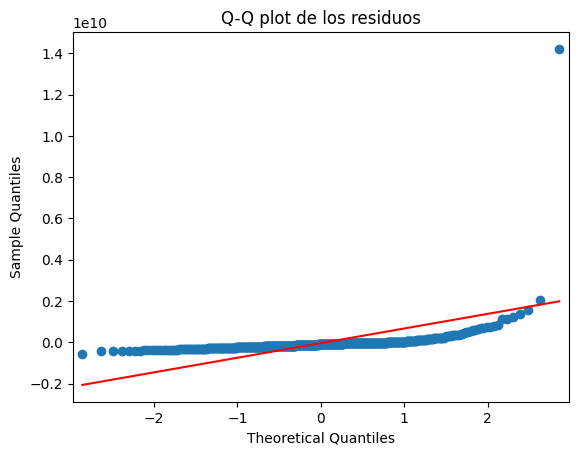

In [50]:
# 4. Gráfico Q-Q (normalidad de los residuos)
plt.figure(figsize=(6,6))
sm.qqplot(residuals, line="s")
plt.title("Q-Q plot de los residuos")
plt.savefig(OUTPUT_DIR + "arima_auto_q_q_residuos.png", dpi=300)
plt.show()